<h3 style="color: pink;">PROYECTO 2 ESTADÍSTICA</h3>
<p>Karen Agudelo Toro, c.c. 1036250737</p>
<p>Alejandro Loturco Acevedo, c.c. 1005040605</p>

<h4> Importación librerias</h4>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

<h4>Funciones</h4>

In [14]:
def informacion(dat,categorico=False):
    """Con el ingreso de una serie de datos, devuelve una lista con la media, 
    mediana, moda, SD, MAD, varianza, IQR, CV y CVM."""
    lista = []    
    if categorico == False:
        # Intentamos tratar los datos como numéricos
        dat = pd.to_numeric(dat)
        lista.append(np.mean(dat))  # media
        lista.append(np.median(dat))  # mediana
        moda = dat.mode().iloc[0] if not dat.mode().empty else np.nan #Si no es categorico calcula la moda
        lista.append(moda)
        lista.append(np.std(dat))  # SD
        lista.append(stats.median_abs_deviation(dat))  # MAD
        lista.append(np.var(dat))  # Varianza
        Q1 = np.percentile(dat, 25)
        Q3 = np.percentile(dat, 75)
        lista.append(Q3 - Q1)  # IQR
        lista.append(dat.std(ddof=1) / dat.mean() * 100)  # CV
        lista.append((stats.median_abs_deviation(dat)/ np.median(dat)) if np.median(dat) != 0 else np.nan)  # CVM
    elif categorico == True:
        lista = [np.nan] * 9  
        lista[2] = dat.mode().iloc[0] if not dat.mode().empty else np.nan  
    
    return lista

def atipicos (valor):  
    """Con el ingreso de una serie de datos, devuelve una lista con los datos 
    atipicos y la cantidad de estos."""  
    atipico = []
    valor = pd.to_numeric(valor)
    Q1 = np.nanpercentile(valor,25)    
    Q3 =np.nanpercentile(valor,75)
    iqr = Q3-Q1

    for x in valor:
        if x < (Q1 - 1.5*iqr) :
            atipico.append(x)
        elif x > (Q3 + 1.5*iqr):
            atipico.append(x)
            
    cont = len(atipico)
    return  cont,atipico

def mostrar_atipicos(lista : list, df):
    """Recibe una lista de variables y un dataframe, y muestra la 
    cantidad de datos atipicos y los datos atipicos para cada variable."""
    for i in range(len(lista)):
        cont,datos = atipicos(df[lista[i]])
        print(f"{lista[i]} tiene {cont} datos atipicos")
        print("Los datos atipicos son:")
        print(datos)
        print("\n")

def extraer_y_promediar(df, indices_dict, nombres_cols):
    """Extrae de un dataframe las columnas especificadas por los índices y nombres 
    de columnas, y devuelve la media de cada fila."""
    columnas = [indices_dict[n] for n in nombres_cols]
    data_temp = df.iloc[:, columnas].copy()
    data_temp.columns = nombres_cols

    for col in nombres_cols:
        data_temp[col] = pd.to_numeric(data_temp[col], errors='coerce')
        data_temp[col] = data_temp[col].fillna(data_temp[col].mean())

    return data_temp.mean(axis=1)

def convertir_numericas(df, variables_numericas):
    """Convierte las columnas especificadas en el dataframe a tipo numérico."""
    for i in variables_numericas:
        df[i] = pd.to_numeric(df[i], errors='coerce')
    return df

def test_normalityKS(datos, variable): # Pruaba de Normalidad Kolmogorov-Smirnof 
    """
    data: arreglo de datos a evaluar la normalidad
    variable: string con el nombre de la variable 
    """  
    print(f"\n Análisis de normalidad por Kolmogorov-Smirnov para '{variable}'")

    # Kolmogorov-Smirnov (KS) test
    ks_stat, ks_p = stats.kstest(datos, 'norm', args=(np.mean(datos), np.std(datos)))
    print(f" Estadístico = {ks_stat:.4f}, p-valor = {ks_p:.4f}")
    return ks_stat, ks_p

def t_test_paired (before,after,x,y):#prueba T para datos pareados
    """
    before: variable antes 
    after: variable después
    """    
    t_stat, p_value = ttest_rel(before, after)    
    print(f"Prueba t para muestras pareadas en los datos {x} y {y}, P-valor: {p_value:.4f}")
    
def validacion_prueba_t(df, variables_numericas, dife = pd.DataFrame()):
    for i in variables_numericas[1:]:    
            data_tratada =  []
            for j in range(len(df['aveOralM'])):
                    cal =df[i][j]- df['aveOralM'][j] 
                    data_tratada.append(cal)
            dife[f'{i}-aveOralM'] = data_tratada
            _,p = test_normalityKS(dife[f'{i}-aveOralM'],f'{i}-aveOralM')
            if p < 0.05:
                    print("\n")
                    print(f"Los datos de {i}-aveOralM no siguen una distribución normal")
                    print("\n ")
                    atipico = []
                    Q1 = np.nanpercentile(dife[f'{i}-aveOralM'],25)    
                    Q3 =np.nanpercentile(dife[f'{i}-aveOralM'],75)
                    iqr = Q3-Q1
                    for x in range(len(dife[f'{i}-aveOralM'])):
                            if dife[f'{i}-aveOralM'][x] > (Q1 - 1.5*iqr) and dife[f'{i}-aveOralM'][x] < (Q3 + 1.5*iqr):
                                    atipico.append(dife[f'{i}-aveOralM'][x])                                        
                            else:
                                    atipico.append(np.nan)
                                    df[f'{i}'][x] = np.nan
                    dife[f'{i}-aveOralM'] = atipico
    return dife 

<p>Diccionario para almacenar las variables y sus índices (columnas del CSV).<br>
Lista usada para la extraccion de las variables numericas a promediar</p>

In [5]:
cols = {'aveOralM':115,
'Max1R13_1':3,
'Max1R13_2':31,
'Max1R13_3':59,
'Max1R13_4':87,
'Max1L13_1':4,
'Max1L13_2':32,
'Max1L13_3':60,
'Max1L13_4':88,
'T_Max1': 26,
'T_Max2': 54,
'T_Max3': 82,
'T_Max4': 110,
'T_FHCC1': 19,
'T_FHCC2': 47,
'T_FHCC3': 75,
'T_FHCC4': 103
}

variables_numericas = [
    'aveOralM',  
    'PromMax1R13',
    'PromMax1L13',
    'PromT_Max',
    'PromT_FHCC'
]

<h3><strong>Punto 1</strong></h3>
<p>Se realiza la lectura de la base de datos junto con el tratamiento adecuado de los datos. <br><br>
La variable <strong>aveOralM</strong> se extrae directamente y se incorpora al diccionario. <br><br>
Por otro lado, las variables que deben promediarse (<em>Max1R13, Max1L13, T_Max, TF_HCC</em>) se obtienen mediante una función que ejecuta iteraciones en función de la variable indicada.<br><br>
Una vez extraídas, se calculan sus promedios y también se agregan al diccionario.<br><br>
Luego de recolectar toda la información relevante, se construye el diccionario resultados utilizando una función que calcula los estadísticos solicitados.<br>
Finalmente, el diccionario se convierte en un <em>DataFrame</em>.</p>


In [6]:
csv = pd.read_csv(r'FLIR_groups1and2.csv', delimiter=';')
csv = csv.iloc[2:].reset_index(drop=True)
 
columnas = ['aveOralM']
indices = [cols[col] for col in columnas]


csv_filter = csv.iloc[:, indices].copy()
csv_filter.columns = columnas

def extraer_y_promediar(df, indices_dict, nombres_cols):
    """Extrae de un dataframe las columnas especificadas por los índices y nombres 
    de columnas, y devuelve la media de cada fila."""
    columnas = [indices_dict[n] for n in nombres_cols]
    data_temp = df.iloc[:, columnas].copy()
    data_temp.columns = nombres_cols

    for col in nombres_cols:
        data_temp[col] = pd.to_numeric(data_temp[col], errors='coerce')
        data_temp[col] = data_temp[col].fillna(data_temp[col].mean())

    return data_temp.mean(axis=1)

csv_filter.loc[:, 'PromMax1R13'] = extraer_y_promediar(csv, cols, ['Max1R13_1','Max1R13_2','Max1R13_3','Max1R13_4'])
csv_filter.loc[:, 'PromMax1L13'] = extraer_y_promediar(csv, cols, ['Max1L13_1','Max1L13_2','Max1L13_3','Max1L13_4'])
csv_filter.loc[:, 'PromT_Max'] = extraer_y_promediar(csv, cols, ['T_Max1','T_Max2','T_Max3','T_Max4'])
csv_filter.loc[:, 'PromT_FHCC'] = extraer_y_promediar(csv, cols, ['T_FHCC1','T_FHCC2','T_FHCC3','T_FHCC4'])

convertir_numericas(csv_filter, variables_numericas)

resultados = {'': ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV", "CVM"],    
    'aveOralM': informacion(csv_filter['aveOralM']),
    'PromMax1R13': informacion(csv_filter['PromMax1R13']),
    'PromMax1L13': informacion(csv_filter['PromMax1L13']),	
    'PromT_Max': informacion(csv_filter['PromT_Max']),
    'PromTF_HCC': informacion(csv_filter['PromT_FHCC'])
}

df_estadisticas = pd.DataFrame(resultados)
csv_filter.to_csv('FLIR_groups1and2_replace.csv',  sep=';', decimal=',',index=False)

Visualizacion del dataframe creado con los estadisticos creados

In [7]:
print("Resumen estadístico completo:\n")
print(df_estadisticas)

Resumen estadístico completo:

              aveOralM  PromMax1R13  PromMax1L13  PromT_Max  PromTF_HCC
0     Media  37.028382    35.597916    35.613185  36.088027   34.574274
1   Mediana  36.940000    35.550000    35.575000  36.031250   34.605816
2      Moda  36.890000    35.677500    35.665000  36.032500   34.407500
3        SD   0.509252     0.564823     0.540556   0.481372    0.660366
4       MAD   0.200000     0.302500     0.301296   0.246250    0.366250
5  Varianza   0.259338     0.319025     0.292201   0.231719    0.436083
6       IQR   0.362500     0.603750     0.603125   0.493125    0.745000
7        CV   1.375978     1.587452     1.518598   1.334538    1.910930
8       CVM   0.005414     0.008509     0.008469   0.006834    0.010583


<h4><strong>Comparación SD Y MAD</strong></h4>


<h5 style="color: pink;">aveOralM</h5>
<p><strong>SD</strong>: 0.509252 <br>
<strong>MAD</strong>:  0.200000 

$\frac{0.2}{0.51} = 0.4$<br>
1 - 0.4 = 0.6 ----> 60%<br></p>
Esta relación es la mayor de todas, lo cual sugiere la presencia de datos atípicos y alta dispersión de esta categoría

<h5 style="color: pink;">PromMax1R13</h5>
<p><strong>SD</strong>: 0.564823  <br>
<strong>MAD</strong>:  0.302500 

$\frac{0.3}{0.5} = 0.6$<br><br>
1 - 0.6 = 0.4 ----> 40% <br></p>

<h5 style="color: pink;">PromMax1L13</h5>
<p><strong>SD</strong>: 0.708276   <br>
<strong>MAD</strong>:  0.398750 

$\frac{0.4}{0.7} = 0.57$<br><br>
1 - 0.57 = 0.43 ----> 43% <br></p>

<h5 style="color: pink;">PromT_Max </h5>
<p><strong>SD</strong>: 0.547745   <br>
<strong>MAD</strong>:  0.308750 

$\frac{0.31}{0.5} = 0.62$<br><br>
1 - 0.62 = 0.38 ----> 38% <br></p>

<h5 style="color: pink;">PromTF_HCC</h5>
<p><strong>SD</strong>: 0.658736   <br>
<strong>MAD</strong>:  0.381250

$\frac{0.4}{0.6} = 0.66$<br><br>
1 - 0.66 = 0.34 ----> 34% <br></p>
Esta relación es la menor de todas, lo cual sugiere una distribución bastante simétrica de los datos y la no presencia de datos atípicos. 
</p>

<h3><strong>Datos atípicos</strong></h3>

In [8]:
print(variables_numericas)
print(csv_filter)
mostrar_atipicos(variables_numericas, csv_filter)

['aveOralM', 'PromMax1R13', 'PromMax1L13', 'PromT_Max', 'PromTF_HCC']
      aveOralM  PromMax1R13  PromMax1L13  PromT_Max  PromTF_HCC
0        36.59    35.030000    34.400000  35.635000   33.477500
1        37.19    34.550000    33.930000  35.092500   34.055000
2        37.34    35.652500    34.277500  35.860000   34.827500
3        37.09    35.222500    34.385000  34.965000   34.422500
4        37.04    35.545000    34.910000  35.587500   35.160000
...        ...          ...          ...        ...         ...
1015     36.99    35.642500    34.857500  35.677500   35.347500
1016     37.19    35.982500    35.427500  36.452500   35.217500
1017     37.59    36.407500    35.870000  35.965000   35.240000
1018     37.29    35.723915    34.614747  35.766412   34.822689
1019     37.19    35.707500    34.887500  35.890000   34.650000

[1020 rows x 5 columns]
aveOralM tiene 108 datos atipicos
Los datos atipicos son:
[37.79, 36.14, 35.99, 37.79, 37.99, 38.69, 38.54, 38.59, 36.09, 37.79, 38.09, 3

Antes de realizar la prueba T para muestras pareadas, debemos verificar la normalidad de la distribución de las diferencias.

In [35]:
def transformar_y_analizar(df, columnas, test_func):
    """
    Para cada columna en `columnas`, crea una nueva columna con sufijo '_filter'
    donde se resta la mediana, aplica una prueba de normalidad y muestra los atípicos.
    Parámetros:
    - df: DataFrame original
    - columnas: lista de nombres de columnas numéricas
    - test_func: función que aplica la prueba de normalidad (ej. test_normalityKS)
    """
    for col in columnas:
        med = df[col].median()
        col_nueva = f'{col}_filter'
        df[col_nueva] = df[col] - med
        datos_trasnformados, lambda_ = stats.boxcox(df[col_nueva])
        print(f"\nResultados para la variable transformada: {col_nueva}")
        _, _ = test_func(df[col_nueva], col_nueva)
        return datos_trasnformados, lambda_
        


In [36]:
variables_a_filtrar = ['aveOralM','PromMax1R13', 'PromMax1L13', 'PromT_Max', 'PromTF_HCC']
transformar_y_analizar(csv_filter, variables_a_filtrar, test_normalityKS)

ValueError: Data must be positive.

<p><strong>Función para verificar la normalidad de la distribución de las frecuencias</strong><br>

<h4><strong>Histograma</strong></h4>


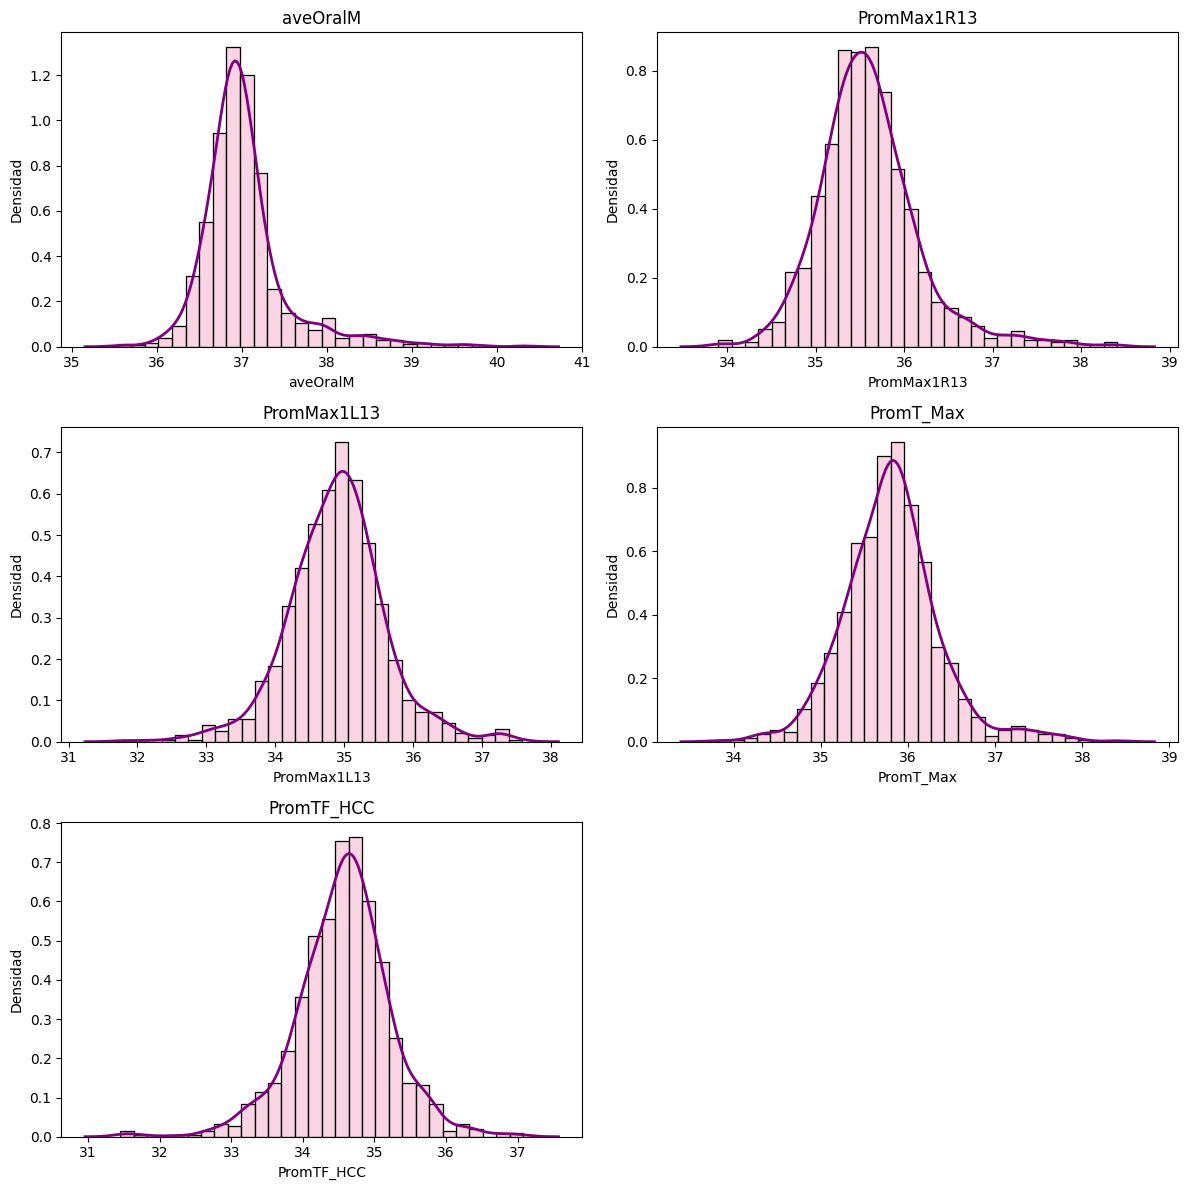

In [38]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(variables_numericas):
    plt.subplot(3, 2, i + 1)  # Adjusted to a 3x2 grid
    sns.histplot(csv_filter[col], bins=30, color="#F7C6D9", stat="density")
    sns.kdeplot(csv_filter[col], color="purple", linewidth=2)
    plt.title(f"{col}")
    plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

<p><strong>Histograma aveOralM</strong><br>
<p>Se observa una alta concentración de datos pero no hay una simetría perfecta, hay una distribución asimétrica a la derecha. Por lo tanto, no parece completamente normal<p><br>
<p><strong>Histograma PromMax1R</strong><br>




<h4><strong>Boxplots</strong></h4>

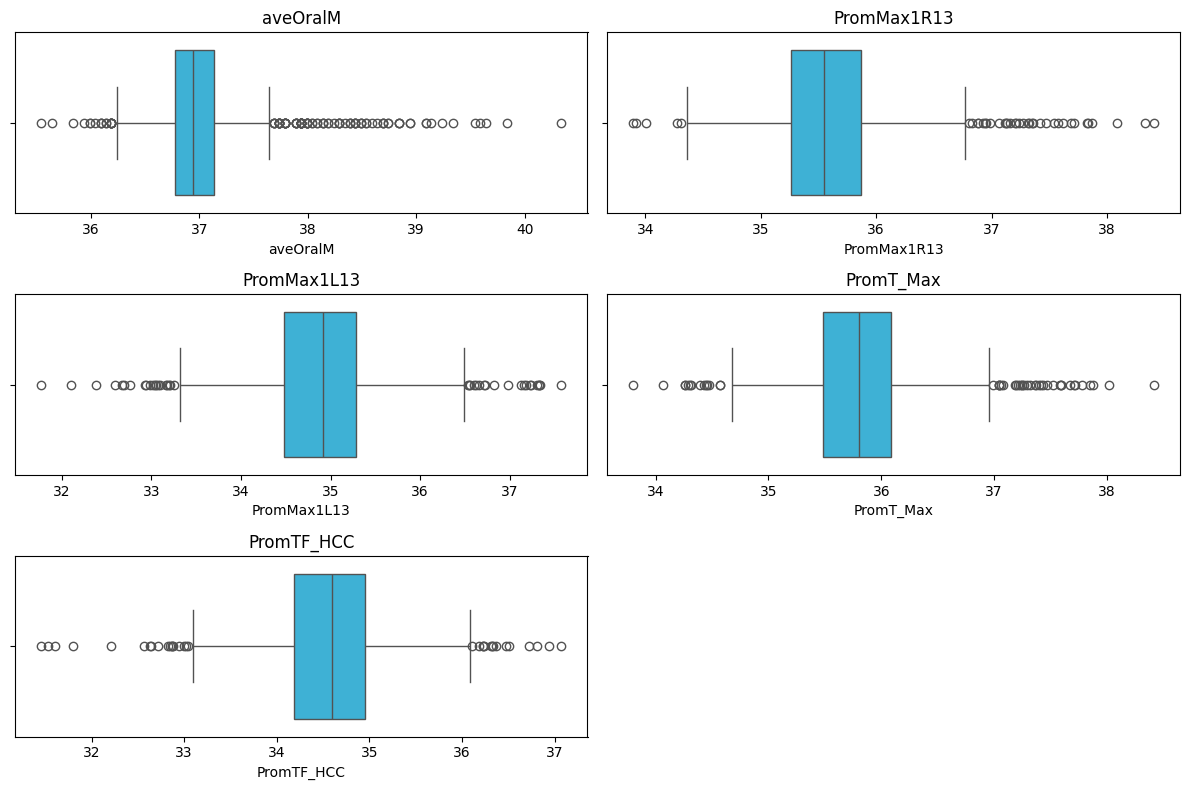

In [40]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(variables_numericas):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=csv_filter[col], color="#25beee")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

<h4><strong>Matriz de correlación</strong></h4>

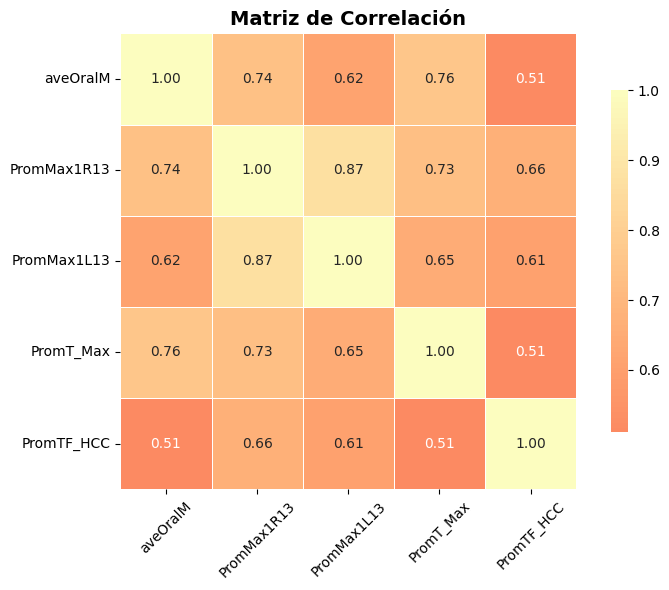

In [41]:
matrix = csv_filter[variables_numericas].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap='magma',      
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={"shrink": .75})
plt.title("Matriz de Correlación", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h4><strong>Datos atípicos</strong></h4>

In [ ]:
med = csv_filter['aveOralM'].median()  # Use the median as a scalar value
lista_prueba = []
for i in csv_filter['aveOralM']:
    lista_prueba.append((i - med))  # Subtract the scalar median from each value
    
csv_filter['aveOralM_filter'] = lista_prueba

_, _ = test_normalityKS(csv_filter['aveOralM_filter'], 'aveOralM_filter')

mostrar_atipicos(['aveOralM_filter'], csv_filter)

In [12]:
data1 = csv_filter['aveOralM']
data2 = csv_filter['PromMax1R13']
data_tratada =  []
for i in range(len(data1)):
        cal = data1[i] - data2[i]
        data_tratada.append(cal)

test_normalityKS(data_tratada, 'PromMax1R13')

Resumen estadístico completo:

Análisis de normalidad por Kolmogorov-Smirnov para 'PromMax1R13'
 Estadístico = 0.0300, p-valor = 0.3130


np.float64(0.31299255527185965)